In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [485]:
from pathlib import Path
import json
import cv2
import os
import math
from datetime import datetime
from typing import Union
from PIL import ImageDraw, ImageFont
import matplotlib.pyplot as plt
from matplotlib import patches, patheffects
from collections import defaultdict, namedtuple
from sklearn.preprocessing import MultiLabelBinarizer
import random
import pandas as pd
import numpy as np

In [486]:
import torch
import torchvision
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader, Dataset

In [4]:
PATH = Path('./VOCdevkit/VOC2007/')
JSON_PATH = Path('./json')

In [5]:
img_size = 300
batch_size = 32

In [6]:
torch.cuda.set_device(2)

In [7]:
torch.cuda.current_device()

2

# EDA

In [8]:
list(PATH.iterdir())

[PosixPath('VOCdevkit/VOC2007/Annotations'),
 PosixPath('VOCdevkit/VOC2007/model-bb1-s1.pth'),
 PosixPath('VOCdevkit/VOC2007/JPEGImages'),
 PosixPath('VOCdevkit/VOC2007/model_tmp.pth'),
 PosixPath('VOCdevkit/VOC2007/model-bb1-s2.pth'),
 PosixPath('VOCdevkit/VOC2007/model-cls-s1.pth'),
 PosixPath('VOCdevkit/VOC2007/model-cls-s2.pth'),
 PosixPath('VOCdevkit/VOC2007/ImageSets'),
 PosixPath('VOCdevkit/VOC2007/SegmentationClass'),
 PosixPath('VOCdevkit/VOC2007/tmp'),
 PosixPath('VOCdevkit/VOC2007/mode_tmp.pth'),
 PosixPath('VOCdevkit/VOC2007/JPEGImages_300_300'),
 PosixPath('VOCdevkit/VOC2007/.ipynb_checkpoints'),
 PosixPath('VOCdevkit/VOC2007/SegmentationObject')]

In [9]:
list(JSON_PATH.iterdir())

[PosixPath('json/pascal_val2007.json'),
 PosixPath('json/pascal_test2007.json'),
 PosixPath('json/pascal_val2012.json'),
 PosixPath('json/pascal_train2007.json'),
 PosixPath('json/pascal_train2012.json')]

## Metadata

In [10]:
annotations = json.load(open(JSON_PATH/'pascal_train2007.json'))

In [11]:
annotations.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [12]:
annotations['categories']

[{'supercategory': 'none', 'id': 1, 'name': 'aeroplane'},
 {'supercategory': 'none', 'id': 2, 'name': 'bicycle'},
 {'supercategory': 'none', 'id': 3, 'name': 'bird'},
 {'supercategory': 'none', 'id': 4, 'name': 'boat'},
 {'supercategory': 'none', 'id': 5, 'name': 'bottle'},
 {'supercategory': 'none', 'id': 6, 'name': 'bus'},
 {'supercategory': 'none', 'id': 7, 'name': 'car'},
 {'supercategory': 'none', 'id': 8, 'name': 'cat'},
 {'supercategory': 'none', 'id': 9, 'name': 'chair'},
 {'supercategory': 'none', 'id': 10, 'name': 'cow'},
 {'supercategory': 'none', 'id': 11, 'name': 'diningtable'},
 {'supercategory': 'none', 'id': 12, 'name': 'dog'},
 {'supercategory': 'none', 'id': 13, 'name': 'horse'},
 {'supercategory': 'none', 'id': 14, 'name': 'motorbike'},
 {'supercategory': 'none', 'id': 15, 'name': 'person'},
 {'supercategory': 'none', 'id': 16, 'name': 'pottedplant'},
 {'supercategory': 'none', 'id': 17, 'name': 'sheep'},
 {'supercategory': 'none', 'id': 18, 'name': 'sofa'},
 {'super

In [13]:
annotations['annotations'][0]

{'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]],
 'area': 34104,
 'iscrowd': 0,
 'image_id': 12,
 'bbox': [155, 96, 196, 174],
 'category_id': 7,
 'id': 1,
 'ignore': 0}

In [14]:
annotations['categories'][0]

{'supercategory': 'none', 'id': 1, 'name': 'aeroplane'}

In [15]:
categories = {d['id']:d['name'] for d in annotations['categories']}
categories

{1: 'aeroplane',
 2: 'bicycle',
 3: 'bird',
 4: 'boat',
 5: 'bottle',
 6: 'bus',
 7: 'car',
 8: 'cat',
 9: 'chair',
 10: 'cow',
 11: 'diningtable',
 12: 'dog',
 13: 'horse',
 14: 'motorbike',
 15: 'person',
 16: 'pottedplant',
 17: 'sheep',
 18: 'sofa',
 19: 'train',
 20: 'tvmonitor'}

## Images

In [16]:
IMG_PATH = PATH/'JPEGImages'
list(IMG_PATH.iterdir())[:5]

[PosixPath('VOCdevkit/VOC2007/JPEGImages/007622.jpg'),
 PosixPath('VOCdevkit/VOC2007/JPEGImages/000450.jpg'),
 PosixPath('VOCdevkit/VOC2007/JPEGImages/002505.jpg'),
 PosixPath('VOCdevkit/VOC2007/JPEGImages/003271.jpg'),
 PosixPath('VOCdevkit/VOC2007/JPEGImages/006858.jpg')]

In [17]:
annotations['images'][:5]

[{'file_name': '000012.jpg', 'height': 333, 'width': 500, 'id': 12},
 {'file_name': '000017.jpg', 'height': 364, 'width': 480, 'id': 17},
 {'file_name': '000023.jpg', 'height': 500, 'width': 334, 'id': 23},
 {'file_name': '000026.jpg', 'height': 333, 'width': 500, 'id': 26},
 {'file_name': '000032.jpg', 'height': 281, 'width': 500, 'id': 32}]

In [18]:
def bounding_box(bb):
    """switch x/y coords to be consistent with numpy, convert height/width into top-left/bottom-right"""
    return np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])

# make dictionary {img_id:[(cat_id, bbox), (cat_id, bbox), ...]}
def make_anno_dict(anno_json):
    anno_dict = defaultdict(list)
    for anno in anno_json['annotations']:
        if not anno['ignore']:
    #         bb = bounding_box(anno['bbox'])
            bb = np.array(anno['bbox'])  # matplotlib accepts VOC format bounding box, so no need to convert
            anno_dict[anno['image_id']].append(
                (anno['category_id'], bb))
    return anno_dict

# open image
def load_image(img_path):
    img = cv2.imread(str(img_path)).astype(np.float32)/255
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img_rgb

def show_img(im, figsize=None, ax=None):
    if not ax:
        fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(True)
    return ax


def draw_outline(plt_object, lw):
    plt_object.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])


def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(
        b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)


def draw_text(ax, xy, txt, font_sz=14):
    text = ax.text(*xy, txt,
                   verticalalignment='top', color='white', fontsize=font_sz, weight='bold')
    draw_outline(text, 1)

def show_by_index(idx:int, annotations:dict):
    img_path = str(IMG_PATH/f'{idx:06d}.jpg')
    img = load_image(img_path)
    
    if idx in annotations.keys():
        print(img_path)
        ax = show_img(img, figsize=(12, 12))
        for item in annotations[idx]:
            b = item[1]
            print(f'Bounding box:\nY: {b[1]}\nX: {b[0]}\nHeight: {b[3]}\nWidth: {b[2]}')
            draw_rect(ax, b)
            draw_text(ax, b[:2], categories[item[0]])

In [19]:
train_anno = make_anno_dict(annotations)

VOCdevkit/VOC2007/JPEGImages/005451.jpg
Bounding box:
Y: 102
X: 237
Height: 398
Width: 138
Bounding box:
Y: 356
X: 155
Height: 110
Width: 82
Bounding box:
Y: 361
X: 77
Height: 118
Width: 60
Bounding box:
Y: 395
X: 79
Height: 100
Width: 141


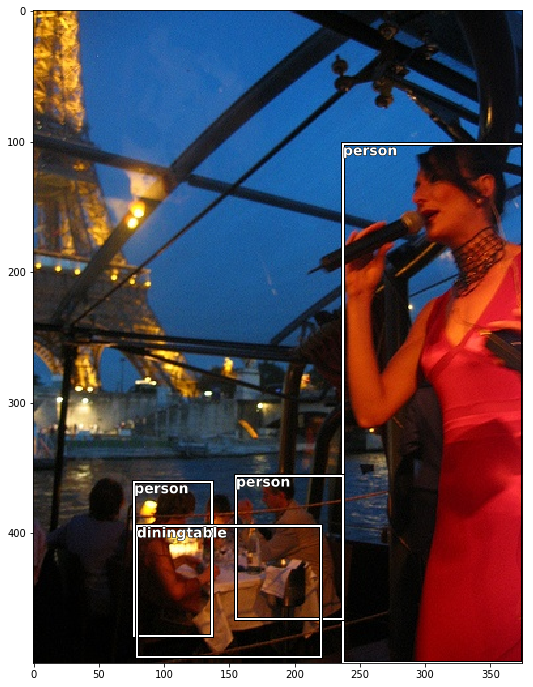

In [20]:
img_ids = list(train_anno.keys())
idx = random.sample(img_ids, 1)[0]
show_by_index(idx, train_anno)

# Image Augmentation

In [67]:
# When using pre-trained networks you should normalized your images in the same way the
# authors of the model did.
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

def denormalize(im):
    """Denormalizes images."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im * imagenet_stats[1]) + imagenet_stats[0]

## For images

In [22]:
def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

def random_crop(x, target_r, target_c):
    """ Returns a random crop"""
    r,c,*_ = x.shape
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(rand_r*(r - target_r)).astype(int)
    start_c = np.floor(rand_c*(c - target_c)).astype(int)
    return crop(x, start_r, start_c, target_r, target_c)

def rotate_cv(im, deg, bbox=False, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if bbox:
        return cv2.warpAffine(im, M, (c,r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im, M, (c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

## For bounding boxes  

width-height format => bounding-box format => pixel format => resized pixel format => bounding-box format => width-height format

In [23]:
def make_bb_px(y, x):
    """Makes an image of size x retangular bounding box"""
    r, c, *_ = x.shape
    Y = np.zeros((r, c))
#     print(y)
    y = hw_bb(y).astype(np.int)
    Y[y[0]:y[2], y[1]:y[3]] = 1.
    return Y


def to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    if len(cols)==0: return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)


def hw_bb(bb): 
    """Transform from width-height format to bounding box format.
    
    width-height: [X, Y, width, height]
    bounding-box: [Y, X, left-bottom, right-top]
    """
    return np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])


def bb_hw(bb): 
    """Transform from bounding box format to width-height format.
    
    width-height: [X, Y, width, height]
    bounding-box: [Y, X, left-bottom, right-top]
    """
    return np.array([bb[1], bb[0], bb[3]-bb[1]+1, bb[2]-bb[0]+1])

# Modelling

In [24]:
import os
os.getcwd()

'/data/xhan/project/Kaggle/pascal'

In [431]:
from src.transform import __boxtools__
from src.ssd import ssd_prior

In [26]:
categories_bb = categories.copy()
categories_bb[0] = 'background'

In [27]:
categories_bb.values()

dict_values(['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor', 'background'])

In [28]:
categories_bb

{1: 'aeroplane',
 2: 'bicycle',
 3: 'bird',
 4: 'boat',
 5: 'bottle',
 6: 'bus',
 7: 'car',
 8: 'cat',
 9: 'chair',
 10: 'cow',
 11: 'diningtable',
 12: 'dog',
 13: 'horse',
 14: 'motorbike',
 15: 'person',
 16: 'pottedplant',
 17: 'sheep',
 18: 'sofa',
 19: 'train',
 20: 'tvmonitor',
 0: 'background'}

## Load data

In [29]:
train_bbox_multi_df = pd.read_csv(PATH/'tmp/train_bbox_multi.csv')
val_bbox_multi_df = pd.read_csv(PATH/'tmp/val_bbox_multi.csv')

In [30]:
train_bbox_multi_df.head(5)

,fn,label,bbox,bbox_300
0,../../VOCdevkit/VOC2007/JPEGImages_300_300/000...,7,155 96 196 174,93 86 117 157
1,../../VOCdevkit/VOC2007/JPEGImages_300_300/000...,15 13,184 61 95 138 89 77 314 259,115 50 59 114 55 63 197 214
2,../../VOCdevkit/VOC2007/JPEGImages_300_300/000...,2 2 15 15 15,8 229 237 271 229 219 105 281 1 0 116 369 2 1 ...,7 137 213 163 205 131 95 169 0 0 105 221 1 0 2...
3,../../VOCdevkit/VOC2007/JPEGImages_300_300/000...,7,89 124 248 88,53 111 149 80
4,../../VOCdevkit/VOC2007/JPEGImages_300_300/000...,1 1 15 15,103 77 272 106 132 87 65 36 194 179 19 50 25 1...,62 82 163 113 79 92 39 39 116 191 11 53 15 200...


In [31]:
IMG_PATH = PATH/'JPEGImages_300_300'

In [432]:
class multiBboxDataset(Dataset):
    def __init__(self, root, dataset, transform=False, target_transform=None, sz=img_size, is_test=False):
        self.root = Path(root)
        self.dataset = self.make_anno_dict(dataset)
        self.sz = img_size
        self.transform = transform
        self.target_transform = target_transform
        self.is_test = is_test
        self.classes = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 
                        'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 
                        'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor', 'background']
        self.class_dict = {i:class_name for i, class_name in enumerate(self.classes)}

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, i):
        image = self.get_image(i)
        labels = self.dataset[i]['labels']
        boxes = self.dataset[i]['boxes']
#         if self.transform:
#             image, boxes = self.tsfm(image, boxes, self.sz)
        boxes = [__boxtools__.hw_bb(bb) for bb in boxes]
        _, boxes, _ = __boxtools__.to_percent_coords(image, np.array(boxes))
        if self.target_transform:
            if not isinstance(boxes, np.ndarray):
                boxes = np.array(boxes)
            locations, labels = self.target_transform(boxes, labels)
        image = normalize(image)
        return image.transpose(2, 0, 1), labels, locations
    
#     def tsfm(self, x, bbox, size):
#         random_degree = (np.random.random()-.50)*20
#         Y = []
#         for b in bbox:
#             Y.append(make_bb_px(b, x))

#         # rotate
#         x_rot = rotate_cv(x, random_degree)
#         Y_rot = [None] * len(Y)
#         for i, y in enumerate(Y):
#             Y_rot[i] = rotate_cv(y, random_degree, bbox=True)
        
#         # random flip
#         if np.random.random() > .5:
#             x_flip = np.fliplr(x_rot).copy()
#             Y_flip = []
#             for i, y in enumerate(Y_rot):
#                 Y_flip.append(bb_hw(to_bb(np.fliplr(y))))
#             _, Y_flip, _ = __boxtools__.to_percent_coords(x_flip, np.array(Y_flip))
#             return x_flip, Y_flip
        
#         Y_rot = np.array([bb_hw(to_bb(y)) for y in Y_rot])
#         _, Y_rot, _ = __boxtools__.to_percent_coords(x_rot, Y_rot)
#         return x_rot, Y_rot
    
    def get_image(self, index):
        image_path = str(self.root/self.dataset[index]['img_name'])
        image = load_image(image_path)
        return image
    
    def make_anno_dict(self, df):
        out = []
        for row in df.values:
            anno_dict = dict()
            anno_dict['img_name'] = row[0].split('/')[-1]
            anno_dict['labels'] = np.array([int(x) for x in row[1].split()])
            bbs = row[3].split()
            anno_dict['boxes'] = np.array([bbs[i*4:i*4+4] for i in range(int(len(bbs)/4))], dtype=np.float)
            out.append(anno_dict)
        return out

In [433]:
SSDBoxSizes = namedtuple('SSDBoxSizes', ['min', 'max'])
SSDSpec = namedtuple('SSDSpec', ['feature_map_size', 'shrinkage', 'box_sizes', 'aspect_ratios'])

specs = [
        SSDSpec(38, 8, SSDBoxSizes(30, 60), [2]),
        SSDSpec(19, 16, SSDBoxSizes(60, 111), [2, 3]),
        SSDSpec(10, 32, SSDBoxSizes(111, 162), [2, 3]),
        SSDSpec(5, 64, SSDBoxSizes(162, 213), [2, 3]),
        SSDSpec(3, 100, SSDBoxSizes(213, 264), [2]),
        SSDSpec(1, 300, SSDBoxSizes(264, 315), [2])
        ]

In [434]:
center_variance = 0.1
size_variance = 0.2
iou_threshold = 0.5
priors = __boxtools__.generate_ssd_priors(specs, image_size=img_size, clip=True)

target_transform = ssd_prior.MatchPrior(priors, center_variance,
                                        size_variance, iou_threshold)

In [458]:
voc_multibb_train = multiBboxDataset(IMG_PATH, train_bbox_multi_df, transform=True,
                                     target_transform=target_transform, sz=img_size, is_test=False)
voc_multibb_valid = multiBboxDataset(IMG_PATH, val_bbox_multi_df, transform=True, target_transform=target_transform,
                                     sz=img_size, is_test=True)

In [459]:
train_dl = DataLoader(voc_multibb_train, batch_size=batch_size, shuffle=True, num_workers=4)
val_dl = DataLoader(voc_multibb_valid, batch_size=batch_size, num_workers=4)

In [460]:
X, y_label, y_bb = next(iter(train_dl))

In [461]:
X.shape, y_label.shape, y_bb.shape

(torch.Size([32, 3, 300, 300]),
 torch.Size([32, 8732]),
 torch.Size([32, 8732, 4]))

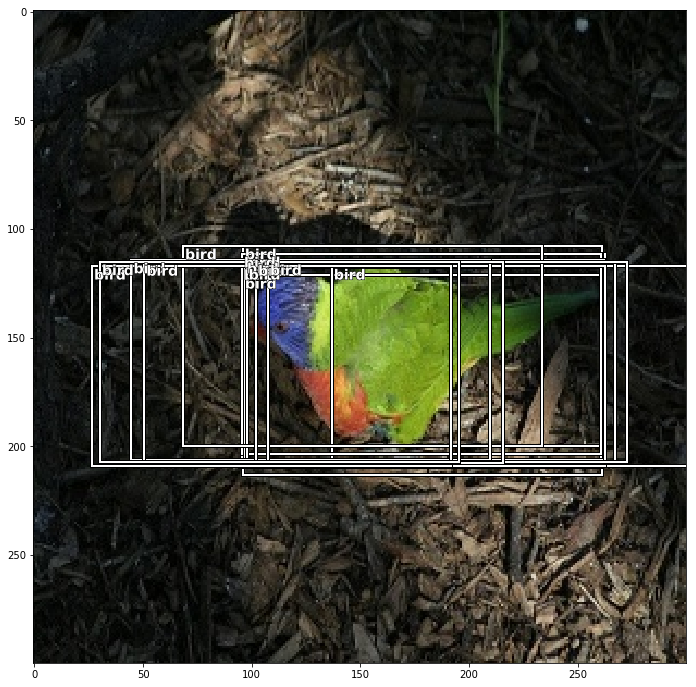

In [503]:
# check augmentation of bounding box
idx = random.randrange(32)
# print(idx)
img = denormalize(X[idx].permute(1, 2, 0).numpy())
ax = show_img(img, figsize=(12, 12))
i_s = np.where(y_label.numpy()[idx] != 0)[0]
# print(i_s)
for i in i_s:
    # center form real box
    bb_real = __boxtools__.convert_locations_to_boxes(y_bb[idx][i].unsqueeze(0), priors,
                                                      center_variance, size_variance)
    _, box, _ = __boxtools__.to_absolute_coords(img, 
                                                boxes=bb_real[i].reshape(1, -1),
                                                labels=None)
    box = __boxtools__.center_hw(box.squeeze())
#     print(box)
#     print(y_label[idx][i].item())
    draw_rect(ax, box)
    text = categories_bb[y_label[idx][i].item()]
    draw_text(ax, box[:2]+1, text)

## Model

In [218]:
# check vgg16 structure
models.vgg16().features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(

In [493]:
class SSDNet(nn.Module):
    def __init__(self, num_classes=21, is_val=False):
        super(SSDNet, self).__init__()
        self.num_classes = num_classes
        self.is_val = is_val
        # 1: vgg16 (0-22), 512x38x38
        vgg16 = models.vgg16(pretrained=True)
        for param in vgg16.parameters():
            param.requires_grad = False
        layers = vgg16.features[:23] # all the way to Conv4-3
        self.top_model = nn.Sequential(*layers)
        self.bn1 = nn.BatchNorm2d(512)
        self.cls1_conv = nn.Conv2d(512, 4*self.num_classes, kernel_size=2, stride=1, padding=1)
        self.reg1_conv = nn.Conv2d(512, 4*4, kernel_size=2, stride=1, padding=1)
        
        # 2: vgg16 (23-29), 1024x19x19
        layers_2 = vgg16.features[23:30]
        self.extra2 = nn.Sequential(
            *layers_2, # Conv5-1, 5-2, 5-3
            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(1024, 1024, kernel_size=1, stride=1),
            nn.BatchNorm2d(1024),
            nn.ReLU()
        )
#         self.bn2 = nn.BatchNorm2d(1024)
        self.cls2_conv = nn.Conv2d(1024, 6*self.num_classes, kernel_size=2, stride=1, padding=1)
        self.reg2_conv = nn.Conv2d(1024, 6*4, kernel_size=2, stride=1, padding=1)
        
        # 3: 512x10x10
        self.extra3 = nn.Sequential(
            nn.Conv2d(1024, 256, kernel_size=1, stride=1),
            nn.BatchNorm2d(256), 
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
#         self.bn3 = nn.BatchNorm2d(512)
        self.cls3_conv = nn.Conv2d(512, 6*self.num_classes, kernel_size=2, stride=1, padding=1)
        self.reg3_conv = nn.Conv2d(512, 6*4, kernel_size=2, stride=1, padding=1)
        
        # 4: 256x5x5
        self.extra4 = nn.Sequential(
            nn.Conv2d(512, 128, kernel_size=1, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
#         self.bn4 = nn.BatchNorm2d(256)
        self.cls4_conv = nn.Conv2d(256, 6*self.num_classes, kernel_size=3, stride=1, padding=1)
        self.reg4_conv = nn.Conv2d(256, 6*4, kernel_size=3, stride=1, padding=1)
        
        # 5: 256x3x3
        self.extra5 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=1, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
#         self.bn5 = nn.BatchNorm2d(256)
        self.cls5_conv = nn.Conv2d(256, 4*self.num_classes, kernel_size=3, stride=1, padding=1)
        self.reg5_conv = nn.Conv2d(256, 4*4, kernel_size=3, stride=1, padding=1)
        
        # 6: 256x1x1
        self.extra6 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=1, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
#         self.bn6 = nn.BatchNorm2d(256)
        self.cls6_conv = nn.Conv2d(256, 4*self.num_classes, kernel_size=3, stride=1, padding=1)
        self.reg6_conv = nn.Conv2d(256, 4*4, kernel_size=3, stride=1, padding=1)
    
    def forward(self, X):
        confidences = []
        locations = []
        X = self.top_model(X)
        # 1
        X1_o = self.bn1(X)
#         X1 = nn.Dropout2d(0.5)(X1_o)
        X1_cls = self.cls1_conv(X1_o)
        X1_reg = self.reg1_conv(X1)
        X1_conf = X1_cls.permute(0, 2, 3, 1).contiguous()
        X1_conf = X1_conf.view(X1_conf.size(0), -1, self.num_classes)
        X1_location = X1_reg.permute(0, 2, 3, 1).contiguous()
        X1_location = X1_location.view(X1_location.size(0), -1, 4)
        confidences.append(X1_conf)
        locations.append(X1_location)
        # 2
        X2_o = self.extra2(X1_o)
#         X2 = nn.Dropout2d(0.5)(X2_o)
        X2_cls = self.cls2_conv(X2_o)
        X2_reg = self.reg2_conv(X2)
        X2_conf = X2_cls.permute(0, 2, 3, 1).contiguous()
        X2_conf = X2_conf.view(X2_conf.size(0), -1, self.num_classes)
        X2_location = X2_reg.permute(0, 2, 3, 1).contiguous()
        X2_location = X2_location.view(X2_location.size(0), -1, 4)
        confidences.append(X2_conf)
        locations.append(X2_location)
        # 3
        X3_o = self.extra3(X2_o)
#         X3 = nn.Dropout2d(0.5)(X3_o)
        X3_cls = self.cls3_conv(X3_o)
        X3_reg = self.reg3_conv(X3)
        X3_conf = X3_cls.permute(0, 2, 3, 1).contiguous()
        X3_conf = X3_conf.view(X1_conf.size(0), -1, self.num_classes)
        X3_location = X3_reg.permute(0, 2, 3, 1).contiguous()
        X3_location = X3_location.view(X3_location.size(0), -1, 4)
        confidences.append(X3_conf)
        locations.append(X3_location)
        # 4
        X4_o = self.extra4(X3_o)
#         X4 = nn.Dropout2d(0.5)(X4_o)
        X4_cls = self.cls4_conv(X4_o)
        X4_reg = self.reg4_conv(X4)
        X4_conf = X4_cls.permute(0, 2, 3, 1).contiguous()
        X4_conf = X4_conf.view(X4_conf.size(0), -1, self.num_classes)
        X4_location = X4_reg.permute(0, 2, 3, 1).contiguous()
        X4_location = X4_location.view(X4_location.size(0), -1, 4)
        confidences.append(X4_conf)
        locations.append(X4_location)
        # 5
        X5_o = self.extra5(X4_o)
#         X5 = nn.Dropout2d(0.5)(X5_o)
        X5_cls = self.cls5_conv(X5_o)
        X5_reg = self.reg5_conv(X5)
        X5_conf = X5_cls.permute(0, 2, 3, 1).contiguous()
        X5_conf = X5_conf.view(X5_conf.size(0), -1, self.num_classes)
        X5_location = X5_reg.permute(0, 2, 3, 1).contiguous()
        X5_location = X5_location.view(X5_location.size(0), -1, 4)
        confidences.append(X5_conf)
        locations.append(X5_location)
        # 6
        X6_o = self.extra6(X5_o)
#         X6 = nn.Dropout2d(0.5)(X6_o)
        X6_cls = self.cls6_conv(X6_o)
        X6_reg = self.reg6_conv(X6)
        X6_conf = X6_cls.permute(0, 2, 3, 1).contiguous()
        X6_conf = X6_conf.view(X6_conf.size(0), -1, self.num_classes)
        X6_location = X6_reg.permute(0, 2, 3, 1).contiguous()
        X6_location = X6_location.view(X6_location.size(0), -1, 4)
        confidences.append(X6_conf)
        locations.append(X6_location)
        
        confidences = torch.cat(confidences, 1)
        locations = torch.cat(locations, 1)
        
        return confidences, locations

In [474]:
def multibox_loss(confidence, predicted_locations, labels, gt_locations, priors,
                  num_classes=21, neg_pos_ratio=3):
    """Calculate multibox losses:
            classification - cross entropy
            bounding boxes - smooth L1 loss
    
    Args:
        confidence (batch_size, num_priors, num_classes): class predictions
        predicted_locations (batch_size, num_priors, 4): predicted locations
        gt_locations (batch_size, num_priors, 4): ground truth locations
        labels (batch_size, num_priors): real labels of all the priors
        priors (batch_size, num_priors, 4): real boxes corresponding all the priors
        num_classes: total number of classes
        neg_pos_ratio: the ratio between the negative examples and positive examples
    """
    with torch.no_grad():
        # derived from cross_entropy=sum(log(p))
        loss = -F.log_softmax(confidence, dim=2)[:, :, 0]
        mask = __boxtools__.hard_negative_mining(loss, labels, neg_pos_ratio)

    confidence = confidence[mask, :]
    classification_loss = F.cross_entropy(confidence.reshape(-1, num_classes), labels[mask])
    pos_mask = labels > 0
    predicted_locations = predicted_locations[pos_mask, :].reshape(-1, 4)
    gt_locations = gt_locations[pos_mask, :].reshape(-1, 4)
    smooth_l1_loss = F.smooth_l1_loss(predicted_locations, gt_locations)
    num_pos = gt_locations.size(0)
    torch.cuda.empty_cache()
    
    return smooth_l1_loss, classification_loss

In [475]:
def val_metrics_multibox(model, valid_dl, priors):
    model.eval()
    total = 0
    sum_l1_loss = 0
    sum_ce_loss = 0
    correct = 0 
    for i, (x, y_label, y_loc) in enumerate(valid_dl):
        batch = y_label.shape[0]
        x = x.cuda().float()
        y_label = y_label.cuda().long()
        y_loc = y_loc.cuda().float()
        confidences, locations = model(x)
        l1_loss, ce_loss = multibox_loss(confidences, locations, y_label, y_loc, priors,
                                         num_classes=21, neg_pos_ratio=3)
        sum_l1_loss += batch*(l1_loss.item())
        sum_ce_loss += batch*(ce_loss.item())
        total += batch
        torch.cuda.empty_cache()
    print(f"Valid L1 loss {(sum_l1_loss/total):.3f}, CE loss: {sum_ce_loss:.3f}")

## Learning Rate Finder

In [476]:
def get_optimizer(model, lr=1e-2, mom=0.9):
    params = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch.optim.SGD(params, lr=lr, momentum=mom)
    return optim

In [477]:
def save_model(m, p): 
    torch.save(m.state_dict(), p)
    
def load_model(m, p):
    checkpoint = torch.load(p)
    m.load_state_dict(checkpoint)
    del checkpoint
    torch.cuda.empty_cache()

In [478]:
def even_mults(start: float, stop: float, n: int)->np.ndarray:
    """Build log-stepped array from `start` to `stop` in `n` steps evenly."""
    mult = stop/start
    step = mult**(1/(n-1))
    return np.array([start*(step**i) for i in range(n)])


def lr_range(lr: Union[float, slice], n)->np.ndarray:
    """Build differential learning rates from `lr`."""
    if not isinstance(lr, slice):
        return lr
    if lr.start:
        lrs = even_mults(lr.start, lr.stop, n)
    else:
        lrs = [lr.stop/10] * (n-1) + [lr.stop]
    return np.array(lrs)

In [479]:
def get_triangular_mom(mom_low=0.85, mom_high=0.95, iterations=50):
    iter1 = int(0.45 * iterations)
    iter2 = int(1.0 * iter1)
    iter3 = iterations - iter1 - iter2

    delta_1 = (mom_high - mom_low) / iter1
    delta_2 = (mom_high - mom_low) / (iter2 - 1)
    moms1 = [mom_high - i * delta_1 for i in range(iter1)]
    moms2 = [mom_low + i * delta_2 for i in range(0, iter2)]
    moms3 = [moms2[-1] for i in range(1, iter3 + 1)]

    return moms1 + moms2 + moms3

In [480]:
def get_triangular_lr(lr_optimal, div_factor, iterations):
    iter1 = int(0.45 * iterations)
    iter2 = int(1.0 * iter1)
    iter3 = iterations - iter1 - iter2

    lr_low = lr_optimal/div_factor
    lr_high = lr_optimal

    delta_1 = (lr_high - lr_low) / iter1
    delta_2 = (lr_high - lr_low) / (iter2 - 1)
    lrs1 = [lr_low + i * delta_1 for i in range(iter1)]
    lrs2 = [lr_high - i * delta_2 for i in range(0, iter2)]
    delta_3 = (lrs2[-1] - lr_low / 100) / iter3
    lrs3 = [lrs2[-1] - i * delta_3 for i in range(1, iter3 + 1)]

    return lrs1 + lrs2 + lrs3

In [481]:
def set_trainable_attr(m, b=True):
    for p in m.parameters(): 
        p.requires_grad = b

def unfreeze(model, l):
    top_model = model.top_model
    set_trainable_attr(top_model[l])

In [482]:
def LR_range_finder_multibox(model, train_dl, priors, lr_low=1e-6, lr_high=1, epochs=4):
    losses = []
    p = PATH/"model_tmp.pth"
    save_model(model, str(p))
    iterations = epochs * len(train_dl)
    lrs = lr_range(slice(lr_low, lr_high), iterations)
    model.train()
    ind = 0
    correct = 0
    for i in range(epochs):
        for x, y_label, y_loc in train_dl:
            optim = get_optimizer(model, lr=lrs[ind])
            x = x.cuda().float()
            y_label = y_label.cuda().long()
            y_loc = y_loc.cuda().float()
            confidences, locations = model(x)
            l1_loss, ce_loss = multibox_loss(confidences, locations, y_label, y_loc, priors,
                                             num_classes=21, neg_pos_ratio=3)
            loss = l1_loss + ce_loss
            optim.zero_grad()
            loss.backward()
            optim.step()
            losses.append(loss.item())
            ind +=1
    load_model(model, str(p))
    torch.cuda.empty_cache()
    return lrs, losses

In [504]:
torch.cuda.empty_cache()

In [ ]:
model = SSDNet().cuda()

In [ ]:
lrs, losses = LR_range_finder_multibox(model, train_dl, priors, lr_low=1e-6, lr_high=1, epochs=2)

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot([np.log10(l) for l in lrs], losses)
plt.show()

## Training

In [ ]:
def one_cycle_multibox(model, train_dl, valid_dl, priors, lr_optimal=1e-4, div_factor=25, epochs=4):
    idx = 0
    iterations = epochs * len(train_dl)
    lrs = get_triangular_lr(lr_optimal, div_factor, iterations)
    moms = get_triangular_mom(0.85, 0.95, iterations)
    train_losses = []
    val_losses = []
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y_label, y_loc in train_dl:
            optim = get_optimizer(model, lr=lrs[idx], mom=moms[idx])
            batch = y_label.shape[0]
            x = x.cuda().float()
            y_label = y_label.cuda().long()
            y_loc = y_loc.cuda().float()
            confidences, locations = model(x)
            l1_loss, ce_loss = multibox_loss(confidences, locations, y_label, y_loc, priors,
                                             num_classes=21, neg_pos_ratio=3)
            loss = l1_loss + ce_loss
            optim.zero_grad()
            loss.backward()
            optim.step()
            idx += 1
            total += batch
            sum_loss += batch*(loss.item())
            torch.cuda.empty_cache()
        print(f"Total train loss: {(sum_loss/total):.3f}")
        val_metrics_multibox(model, valid_dl, priors)

In [ ]:
def training_loop_multibox(model, train_dl, valid_dl, priors, steps=3, lr_optimal=1e-3, div_factor=25, epochs=4):
    for i in range(steps):
        start = datetime.now() 
        train_loss, val_loss = one_cycle_multibox(model, train_dl, valid_dl, priors,
                                                  lr_optimal, div_factor, epochs)
        end = datetime.now()
        t = 'Time elapsed {}'.format(end - start)
        print("----End of step", t)

In [ ]:
model = SSDNet().cuda()

In [ ]:
training_loop_multibox(model, train_edl, val_dl, priors, steps=2, lr_optimal=1e-2, div_factor=25, epochs=2)